In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import collections

from sklearn.metrics import confusion_matrix, auc
from sklearn.neighbors import LocalOutlierFactor

# Data Loading

In [2]:
#Reading .csv
df = pd.read_csv('creditcard.csv')

#Separating feature dimensions from class labels
X_initial = df.iloc[:, :30]
y = df.iloc[:, 30].values

X_initial = X_initial.astype('float')
y = y.astype('float')

# Hyper Parameters

In [3]:
#Number of neighbors for local outlier factor
n_neighbors = 20

#Size of leaf to distinguish between neighbors
leaf_size = 29

#Distance metric hyper parameter
distance_metric = 'minkowski'

#Number of bootstrapping runs
runs = 10

# Initializing Variables & Dictionaries

In [4]:
n = len(X_initial)

#Initializing dictionaries to store results for each run with the format {data[run_number]: [results]}
score = {}
y_true = {}
y_preds = {}
auprc = {}
auroc = {}

# Local Outlier Factor Algorithm & Generating PRC, ROC Curves


Run 1


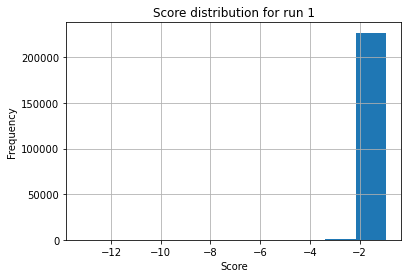

Plotting Precision-Recall and ROC Curves for run 1


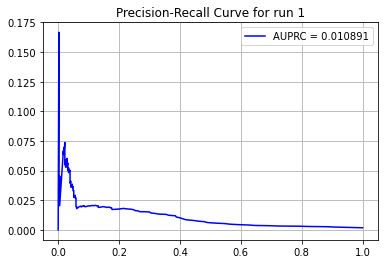

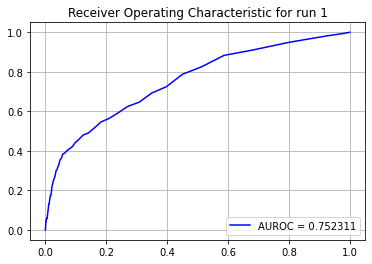


Run 2


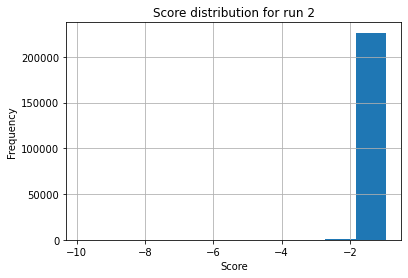

Plotting Precision-Recall and ROC Curves for run 2


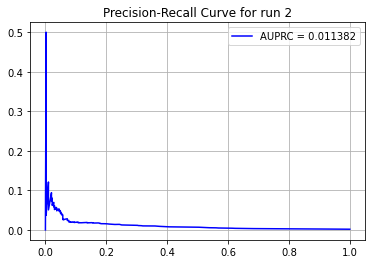

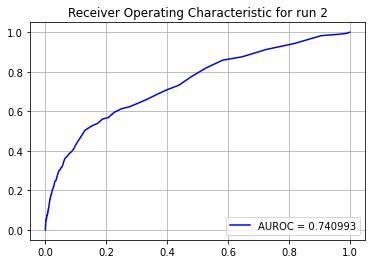


Run 3


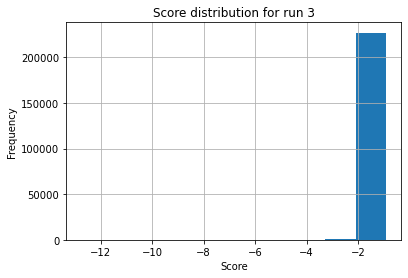

Plotting Precision-Recall and ROC Curves for run 3


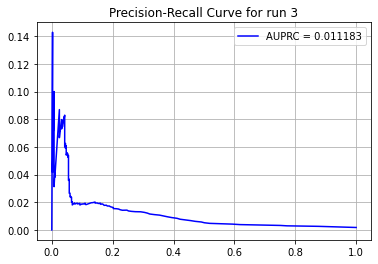

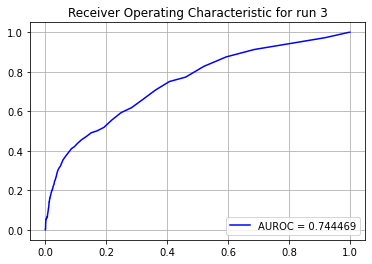


Run 4


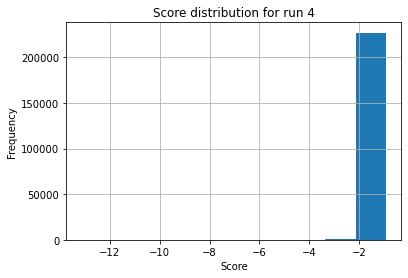

Plotting Precision-Recall and ROC Curves for run 4


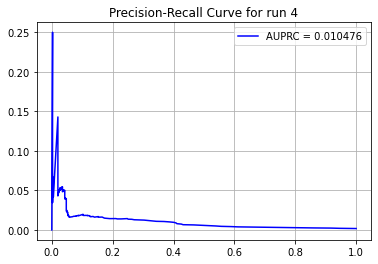

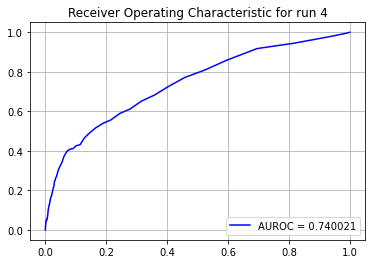


Run 5


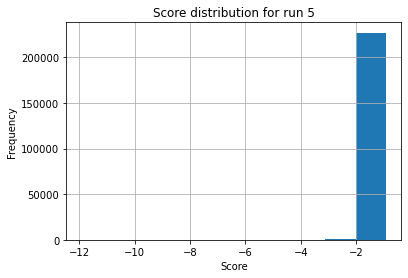

Plotting Precision-Recall and ROC Curves for run 5


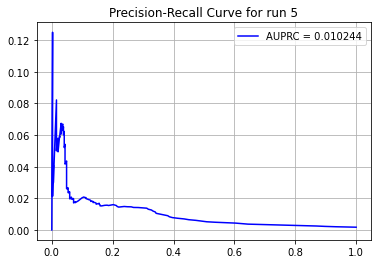

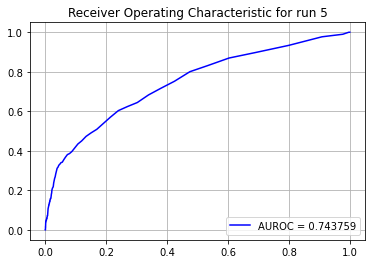


Run 6


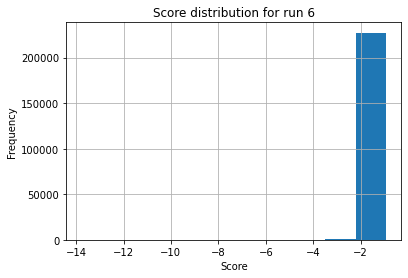

Plotting Precision-Recall and ROC Curves for run 6


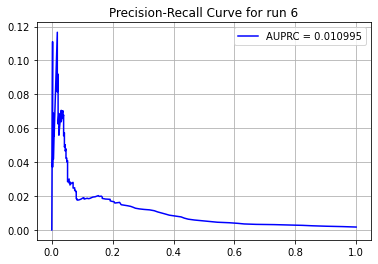

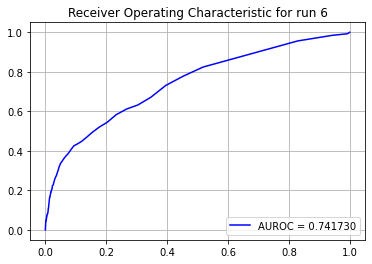


Run 7


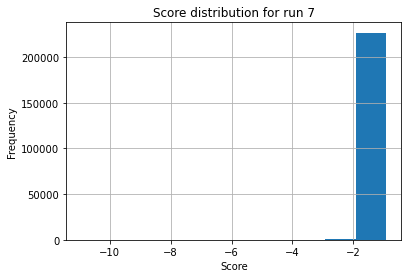

Plotting Precision-Recall and ROC Curves for run 7


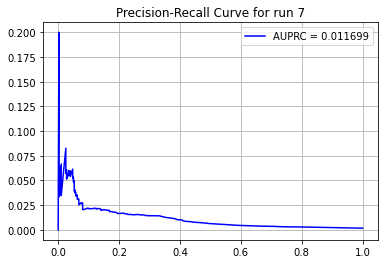

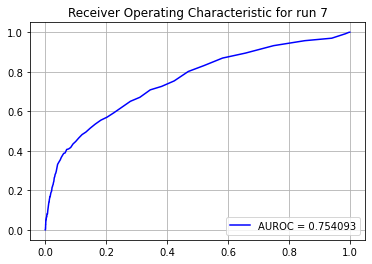


Run 8


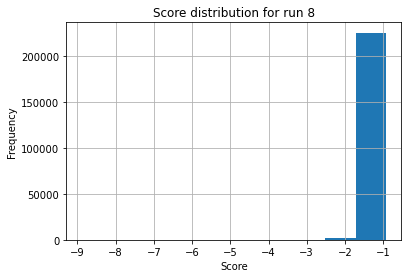

Plotting Precision-Recall and ROC Curves for run 8


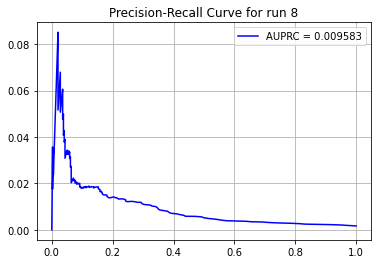

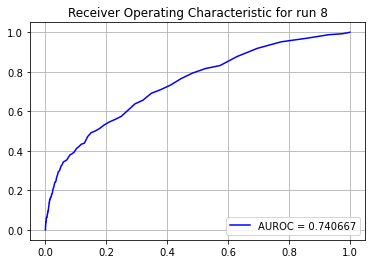


Run 9


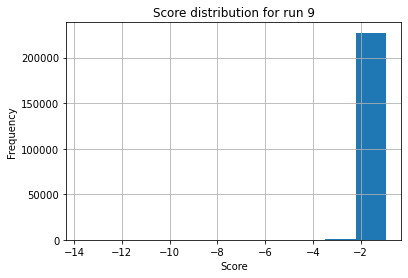

Plotting Precision-Recall and ROC Curves for run 9


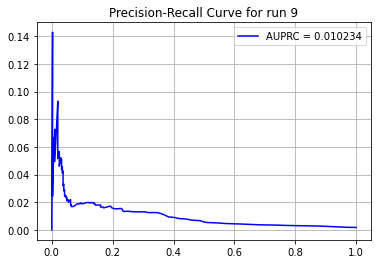

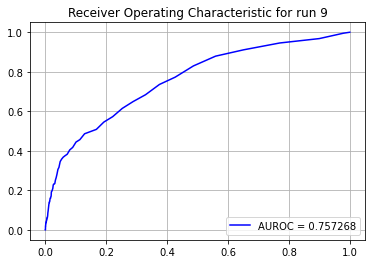


Run 10


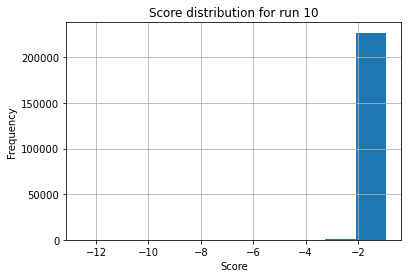

Plotting Precision-Recall and ROC Curves for run 10


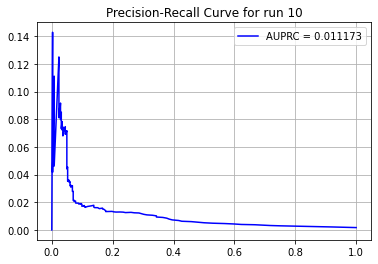

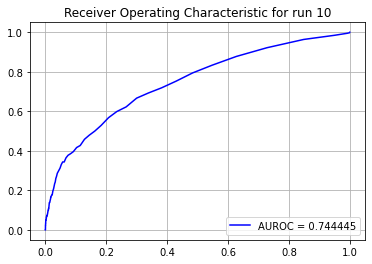

In [5]:
#Starting the loop for bootstrapping runs
for r in range(runs):
    print("")
    print("Run " + str(r+1))
    
    #Generating 80% of n random indexes without replacement
    bootstrap_index = np.random.choice(n, size = int(0.8*n), replace = False)
    
    #Selecting randomly sampled data (features & respective labels) using generated indexes
    X = X_initial.iloc[bootstrap_index, :]
    X = X.reset_index(drop = True)
    
    y_true[r+1] = y[bootstrap_index]
    
    #Initializing Sklearn's LocalOutlierFactor class with hyperparameters defined above
    lof_model = LocalOutlierFactor(n_neighbors = n_neighbors,
                                   algorithm = 'auto',
                                   leaf_size = leaf_size,
                                   metric = distance_metric,
                                   contamination = float(len(y_true[r+1][y_true[r+1] == 1]))/float(len(y_true[r+1][y_true[r+1] == 0])))
    
    #Begin training process to generate list of predicted labels and scores
    y_preds[r+1] = lof_model.fit_predict(X)
    score[r+1] = lof_model.negative_outlier_factor_

    #Re-formatting class labels based on the original set of class labels {0, 1} 
    y_preds[r+1][y_preds == 1] = 0
    y_preds[r+1][y_preds == -1] = 1

    #Plotting histogram of generated scores
    plt.figure()
    plt.title('Score distribution for run ' + str(r+1))
    plt.hist(score[r+1])
    plt.grid()
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()
    
    #Initializing a set of 1000 thresholds from the set (min(score), max(score))
    print("Plotting Precision-Recall and ROC Curves for run " + str(r+1))
    thresholds = np.linspace(score[r+1].min(), score[r+1].max(), num = 1001)[1:]

    #Initializing list of results for current run
    y_preds[r+1] = np.zeros(len(y_true[r+1])) #predicted labels
    recall = np.zeros(len(thresholds)) #recall values
    precision = np.zeros(len(thresholds)) #precision values
    fpr = np.zeros(len(thresholds)) #false positive rate
    
    #Looping through each threshold
    for t in range(len(thresholds)):
        #print("Run " + str(r+1) + ", threshold " + str(t+1))
        
        #Set label = 1 if predicted score is below threshold
        y_preds[r+1][np.where(score[r+1] < thresholds[t])] = 1
        
        #Using Sklearn's confusion_matrix function to generate tn, fp, fn, tp values
        tn, fp, fn, tp = confusion_matrix(y_true[r+1], y_preds[r+1]).ravel()
        
        #Computing recall, precision and false positive rate
        recall[t] = tp/(tp + fn)
        precision[t] = tp/(tp + fp)
        fpr[t] = fp/(fp + tn)

    #Calculating area under the precision-recall curve
    i = np.array(range(1, len(recall)))
    re = recall[i] - recall[i-1]
    pre = precision[i] + precision[i-1]
    auprc[r+1] = np.sum(re * pre)/2
    
    #Plotting Precision-Recall curve
    plt.figure()
    plt.title('Precision-Recall Curve for run ' + str(r+1))
    plt.plot(recall, precision, 'b', label = 'AUPRC = %0.6f' % auprc[r+1])
    plt.grid()
    plt.legend(loc = 'upper right')
    plt.show()

    #Calculating area under the recall curve using Sklearn's auc function
    auroc[r+1] = auc(fpr, recall) 
    
    #Plotting ROC curve
    plt.figure()
    plt.title('Receiver Operating Characteristic for run ' + str(r+1))
    plt.plot(fpr, recall, 'b', label = 'AUROC = %0.6f' % auroc[r+1])
    plt.grid()
    plt.legend(loc = 'lower right')
    plt.show()

# Quantitative Analysis

In [6]:
print("----------------------")
print("AUPRC values per run:")
print(auprc)

print("Mean of AUPRC: " + str(np.mean(list(auprc.values()))))
print("Standard Deviation of AUPRC: " + str(np.std(list(auprc.values()))))
print("----------------------")

print("")
print("----------------------")
print("AUROC values per run:")
print(auroc)

print("Mean of AUROC: " + str(np.mean(list(auroc.values()))))
print("Standard Deviation of AUROC: " + str(np.std(list(auroc.values()))))
print("----------------------")

----------------------
AUPRC values per run:
{1: 0.010890883583416375, 2: 0.011382211535892296, 3: 0.011182669531939672, 4: 0.010475954125747554, 5: 0.010243699308945624, 6: 0.010994713750051255, 7: 0.0116989282189846, 8: 0.00958316965426052, 9: 0.010233725050778157, 10: 0.011172509490454473}
Mean of AUPRC: 0.010785846425047051
Standard Deviation of AUPRC: 0.0006076373207627128
----------------------

----------------------
AUROC values per run:
{1: 0.7523105449050841, 2: 0.7409933845539832, 3: 0.7444690120427988, 4: 0.7400212178485749, 5: 0.7437590539933686, 6: 0.7417298652490741, 7: 0.7540928415086285, 8: 0.7406670335212557, 9: 0.7572680462734984, 10: 0.7444451729728758}
Mean of AUROC: 0.7459756172869142
Standard Deviation of AUROC: 0.0059122740890842265
----------------------
